# Rejection-Inversion for Log-Concave Distributions (RILC) Sampler for Hypergeometric Distribution

In [1]:
import time

import numpy as np
from scipy.special import gammaln
from scipy.optimize import root
from scipy.stats import linregress
import matplotlib.pyplot as plt

import mvhg

In [2]:
def get_log_pk(N, K, n, k):
    log_pk = (gammaln(K+1) - gammaln(k+1) - gammaln(K-k+1) +
              gammaln(N-K+1) - gammaln(n-k+1) - gammaln(N-K-n+k+1) -
              gammaln(N+1) + gammaln(n+1) + gammaln(N-n+1))
    return log_pk

def get_pk(N, K, n, k):
    return np.exp(get_log_pk(N, K, n, k))

In [18]:
N, K, n = 150, 50, 100
N, K, n = N, N - K, n
print(f"N = {N}, K = {K}, n = {n}")

N = 150, K = 100, n = 100


## Part 1: RILC Sampler Hat Function

In [19]:
km = np.floor((n+1) * (K+1) / (N+2)) + 1
ks = np.arange(max(0, n + K - N), min(K,n) + 1)
pks = np.array([get_pk(N, K, n, k) for k in ks])
log_pks = np.array([get_log_pk(N, K, n, k) for k in ks])
xs = np.linspace(ks[0], ks[-1], 500)
log_px = np.interp(xs, ks, log_pks)
px = np.exp(log_px)

In [20]:
px_fun = lambda x: np.exp(np.interp(x, ks, log_pks))
f = lambda x: px_fun(x + 1) / px_fun(x) - (1 + 1/(km - x))
x0 = km + 0.001
x0 = root(f, x0).x.item()

k0 = np.floor(x0 + 1)
log_pk0 = get_log_pk(N, K, n, k0)
log_pk1 = get_log_pk(N, K, n, k0-1)
pk0 = get_pk(N, K, n, k0)
b = log_pk0 - log_pk1
hx = pk0 * np.exp(b * (xs - k0))

print(f"x0 = {x0}, k0 = {np.floor(x0 + 1)}")

x0 = 70.36040472317116, k0 = 71.0


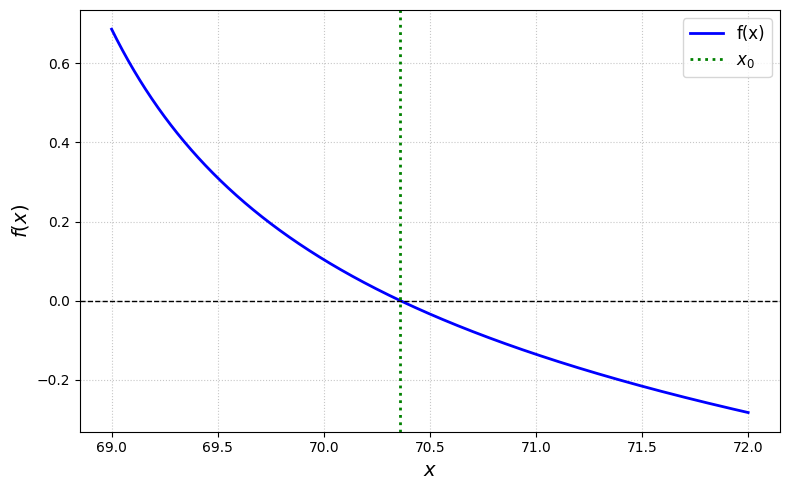

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

xxs = np.linspace(k0 - 2, k0+1, 1000)
ax.plot(xxs, f(xxs), color='blue', linewidth=2, label='f(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label=r'$x_0$')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

ax.set_xlabel(r'$x$', fontsize=14)
ax.set_ylabel(r'$f(x)$', fontsize=14)

ax.grid(True, linestyle=':', alpha=0.7)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

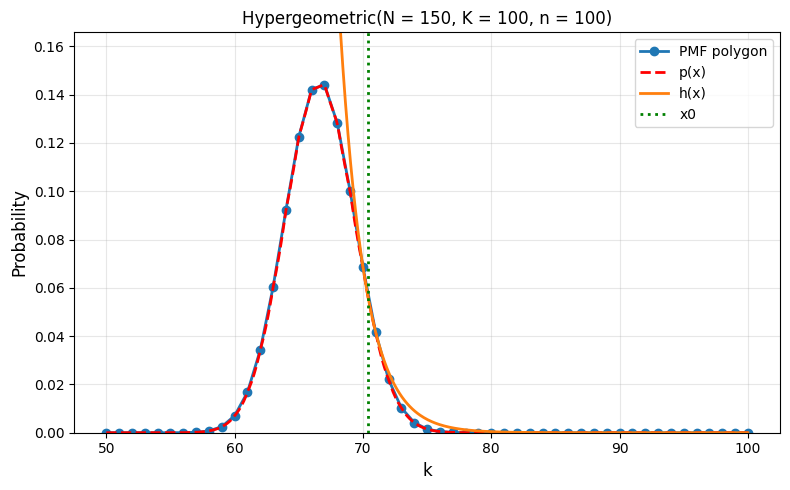

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ks, pks, 'o-', markersize=6, linewidth=2, label='PMF polygon')
ax.plot(xs, px, '--', color='red', linewidth=2, label='p(x)')
ax.plot(xs, hx, linewidth=2, label='h(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label='x0')

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=True, fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0, np.max(pks) * 1.15)
ax.set_title(f"Hypergeometric(N = {N}, K = {K}, n = {n})")

fig.tight_layout()
plt.show()

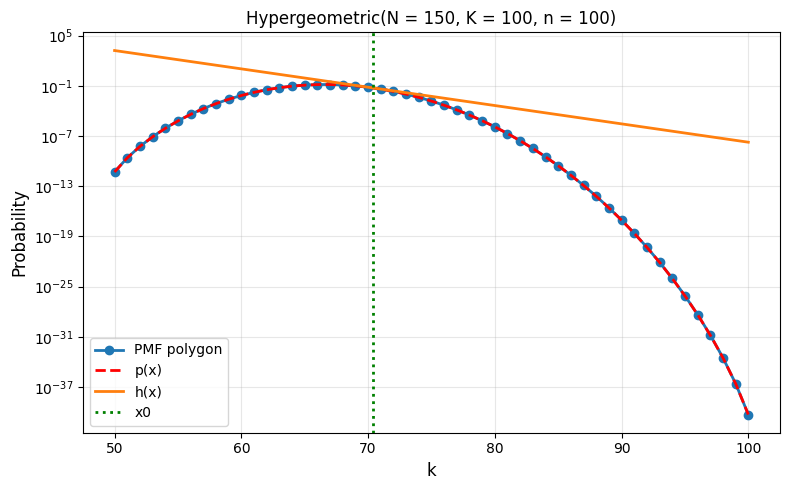

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ks, pks, 'o-', markersize=6, linewidth=2, label='PMF polygon')
ax.plot(xs, px, '--', color='red', linewidth=2, label='p(x)')
ax.plot(xs, hx, linewidth=2, label='h(x)')
ax.axvline(x=x0, color='green', linestyle=':', linewidth=2, label='x0')

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(frameon=True, fontsize=10)
ax.grid(alpha=0.3)
ax.set_yscale('log')
ax.set_title(f"Hypergeometric(N = {N}, K = {K}, n = {n})")

fig.tight_layout()
plt.show()

## Part 2: RILC Sampler Empirical PMF

In [9]:
N, K, n = 46415, 464, 4641

In [10]:
num_samples = 1_000_000
samples = mvhg.hypergeometric(N, K, n, num_samples)

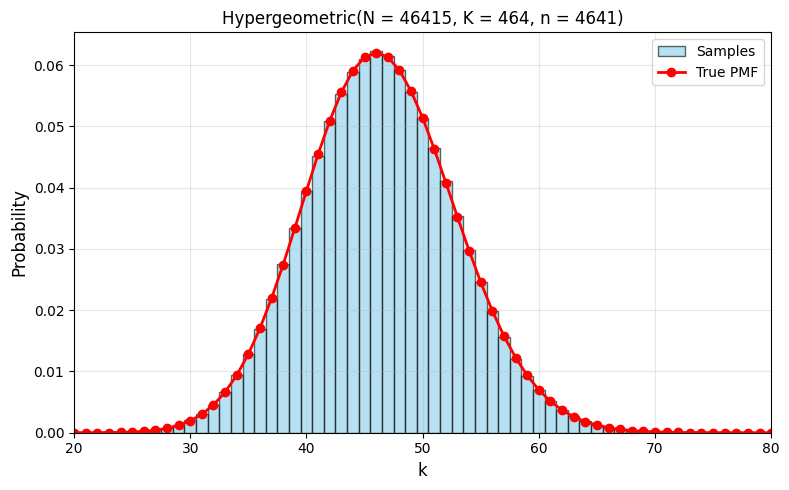

In [11]:
k_min = max(0, n + K - N)
k_max = min(K, n)
ks = np.arange(k_min, k_max + 1)

pks = np.array([get_pk(N, K, n, k) for k in ks])

fig, ax = plt.subplots(figsize=(8,5))

ax.hist(samples, bins=np.arange(k_min - 0.5, k_max + 1.5, 1),
        density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Samples')
ax.plot(ks, pks, 'o-', color='red', linewidth=2, markersize=6, label='True PMF')

ax.set_xlabel('k', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_title(f"Hypergeometric(N = {N}, K = {K}, n = {n})")

ax.set_xlim([20, 80])

fig.tight_layout()
plt.show()

## Part 3: Estimate Time Complexity

In [15]:
sizes = np.logspace(2, 6, num=10, dtype=int)
M = 20
num_samples = 10_000

K_ratios = [0.01, 0.1, 0.5]
n_ratio = 0.1

def time_sampler(N, K, n, num_samples, M):
    times = []
    for _ in range(M):
        start = time.time()
        _ = mvhg.hypergeometric(N, K, n, num_samples, num_max_iter = 10_000)
        times.append(time.time() - start)
    return np.mean(times)

results = {}
for ratio in K_ratios:
    times = []
    for N in sizes:
        K = int(ratio * N)
        n = int(n_ratio * N)
        if K > N or n > N:
            times.append(np.nan)
            continue
        t = time_sampler(N, K, n, num_samples, M)
        print(f"N={N:8d} K={K:6d} n={n:6d} t={t:6f}")
        times.append(t)
    results[ratio] = np.array(times)

N=     100 K=     1 n=    10 t=0.032736
N=     278 K=     2 n=    27 t=0.033282
N=     774 K=     7 n=    77 t=0.033670
N=    2154 K=    21 n=   215 t=0.035314
N=    5994 K=    59 n=   599 t=0.035204
N=   16681 K=   166 n=  1668 t=0.037552
N=   46415 K=   464 n=  4641 t=0.044213
N=  129154 K=  1291 n= 12915 t=0.055756
N=  359381 K=  3593 n= 35938 t=0.085948
N= 1000000 K= 10000 n=100000 t=0.158662
N=     100 K=    10 n=    10 t=0.032651
N=     278 K=    27 n=    27 t=0.033638
N=     774 K=    77 n=    77 t=0.034633
N=    2154 K=   215 n=   215 t=0.036404
N=    5994 K=   599 n=   599 t=0.044998
N=   16681 K=  1668 n=  1668 t=0.058985
N=   46415 K=  4641 n=  4641 t=0.094705
N=  129154 K= 12915 n= 12915 t=0.190390
N=  359381 K= 35938 n= 35938 t=0.548030
N= 1000000 K=100000 n=100000 t=2.280015
N=     100 K=    50 n=    10 t=0.034498
N=     278 K=   139 n=    27 t=0.034948
N=     774 K=   387 n=    77 t=0.035646
N=    2154 K=  1077 n=   215 t=0.037165
N=    5994 K=  2997 n=   599 t=0.042448


K/N=0.010: empirical complexity ≈ O(n^0.42)
K/N=0.100: empirical complexity ≈ O(n^1.04)
K/N=0.500: empirical complexity ≈ O(n^1.28)


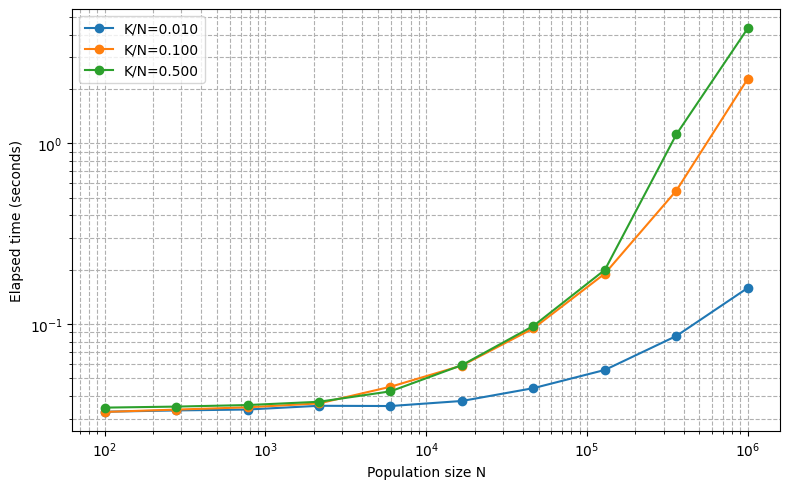

In [17]:
burn_in = 6
fig, ax = plt.subplots(figsize=(8, 5))

for ratio, times in results.items():
    sizes_fit = sizes[burn_in:]
    means_fit = times[burn_in:]
    log_sizes = np.log10(sizes_fit)
    log_means = np.log10(means_fit)
    slope, intercept, _, _, _ = linregress(log_sizes, log_means)
    fit_times = 10**(intercept + slope * np.log10(sizes))
    ax.loglog(sizes, times, "o-", label=f"K/N={ratio:.3f}")
    # ax.loglog(sizes, fit_times, "--", color=ax.lines[-1].get_color(),
    #           label=f"Fit K/N={ratio:.3f}: O(n^{slope:.2f})")
    print(f"K/N={ratio:.3f}: empirical complexity ≈ O(n^{slope:.2f})")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Population size N")
ax.set_ylabel("Elapsed time (seconds)")
ax.legend()
ax.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()